In [1]:
# Numerical
from jax.numpy import mean, var, exp, newaxis   # Arithematic
from jax.numpy import array, zeros, arange  # Array creation routines
from jax.numpy.linalg import solve, eig
from jax.lax import scan 
from jax import jit, jacrev, jacfwd

# Miscellaneous
from functools import partial 
from time import process_time
from ticktack import load_presaved_model
from ticktack.fitting import SingleFitter

# ODEINTs
from ticktack.bogacki_shampine import odeint as BS3
from ticktack.dormand_prince import odeint as DP5

# Visualisation
from pandas import DataFrame
from plotnine import *

In [2]:
parameters = (774.86, 0.25, 0.8, 6.44)

In [3]:
def profile(func, *args, **kwargs) -> tuple:
    """
    Profiles the function, func, with the arguments, args, returning the speed and the variance of the speed.
    """
    time_sample = zeros(10)  # Storing the trials
    
    for i in range(10):
        timer = process_time()             # Starting a timer 
        solution = func(*args, **kwargs)   # Running the model 
        map(array, solution) # Forcing vistation of the values (equivalent to block_until_ready)
        timer = process_time() - timer     # Stopping the timer

        time_sample = time_sample.at[i].set(timer)  # Storing the timer 

    return {
        "average": mean(time_sample.at[1:].get()), 
        "variance": var(time_sample),
        "solution": solution
        }

In [4]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    """
    A linear ode solver that is designed to be compatible with the `ticktack` architecture. 
    """
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None):
        """
        A utility function that is passed through scan(map) to produce the final result.
        """
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)
    step = jit(step)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [5]:
def generate_model(solver, oversample):
    carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
    function_object = SingleFitter(carbon_box_model, "Guttler14")
    function_object.load_data("miyake12.csv")

    def production(t):
        return function_object.steady_state_production

    function_object.compile_production_model(model=production)
    function_object.set_solver(solver)
    function_object.oversample = oversample
    return function_object

In [6]:
def ring_down(single_fitter):
    y0 = single_fitter.steady_state_y0 + 0.01 * \
        single_fitter.cbm._production_coefficients * \
            single_fitter.steady_state_y0

    true_values, _ = single_fitter.cbm.run(
        single_fitter.annual, 
        single_fitter.oversample, 
        single_fitter.production, 
        solver=single_fitter.get_solver(), 
        y0=y0
    )

    return true_values

In [8]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [15]:
import matplotlib.pyplot as plt

In [ ]:
eigenvalues, eigenvectors = eig(cbm._matrix)
newt = arange(0, 100, 1 / 1000)
soln = solve(eigenvectors, cbm._production_coefficients)

def sum_util(j, solution=None, eigenvalues=None, eigenvectors=None, time=None):
    return (solution[j] * exp(eigenvalues[j] * (time - time.min()))[:, newaxis] * eigenvectors.T[j, :])

sum_util = partial(sum_util, solution=soln, eigenvalues=eigenvalues,
    eigenvectors=eigenvectors, time=newt)
sum_util = jit(sum_util)

output = sum(map(sum_util, arange(11)))

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i in range(2):
    axes[i].plot(newt-newt.min(), output[:, i].real)
    axes[i].set_title(cbm.get_nodes()[i])

In [22]:
model = generate_model(DP5, 1000)

states, _ = model.cbm.run(arange(100), model.oversample, model.production, solver=DP5, y0=model.steady_state_y0 + model.cbm._production_coefficients)
states -= model.steady_state_y0

In [25]:
residuals = states[:output.shape[0]] - output

In [115]:
odeint = {"Linear": odeint_linear, "BS3": BS3, "DP5": DP5}

In [126]:
odeint_oversample_resids = {
    "Solver": [],
    "Oversample": [],
    "Time (s)": [],
    "Time Var (s)": [],
    "Accuracy": []
}

In [127]:
single_fitter = generate_model(DP5, 2000)
true_values = ring_down(single_fitter)

In [ ]:
for solver in odeint:
    for oversample in range(10, 1000, 50):
        function_obj = generate_model(odeint[solver], oversample)

        o_profile = profile(ring_down, function_obj)

        # Calculating the residuals
        residuals = o_profile["solution"] - true_values  # Calculating the residuals 
        accuracy = float(mean(residuals))   # Getting the accuracy

        # Added everything to the data frame
        odeint_oversample_resids["Solver"].append(solver)
        odeint_oversample_resids["Oversample"].append(oversample)
        odeint_oversample_resids["Time (s)"].append(float(o_profile["average"]))
        odeint_oversample_resids["Time Var (s)"].append(float(o_profile["variance"]))
        odeint_oversample_resids["Accuracy"].append(abs(accuracy))

In [121]:
odeint_oversample_resids = DataFrame(odeint_oversample_resids)

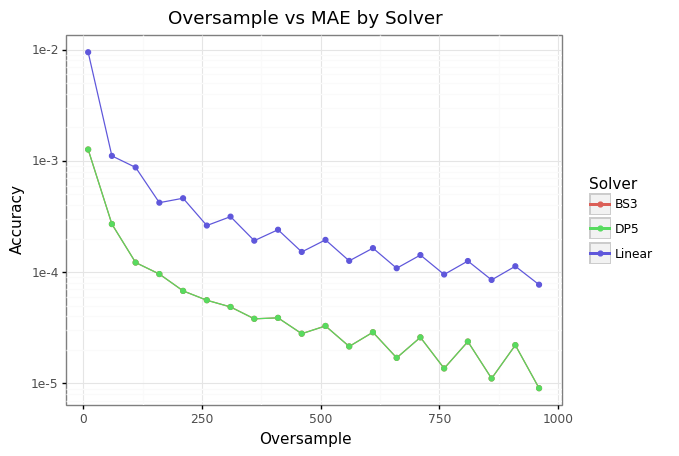

<ggplot: (8758822615929)>

In [122]:
(ggplot(odeint_oversample_resids, 
    aes(
        x="Oversample", 
        y="Accuracy", 
        color="Solver"
    ))
    + theme_bw()
    + geom_line()
    + geom_point()
    + scale_y_log10()
    + ggtitle("Oversample vs MAE by Solver"))

In [123]:
odeint_oversample_resids["ymin"] =\
     odeint_oversample_resids["Time (s)"] -\
     odeint_oversample_resids["Time Var (s)"]

odeint_oversample_resids["ymax"] =\
     odeint_oversample_resids["Time (s)"] +\
     odeint_oversample_resids["Time Var (s)"]

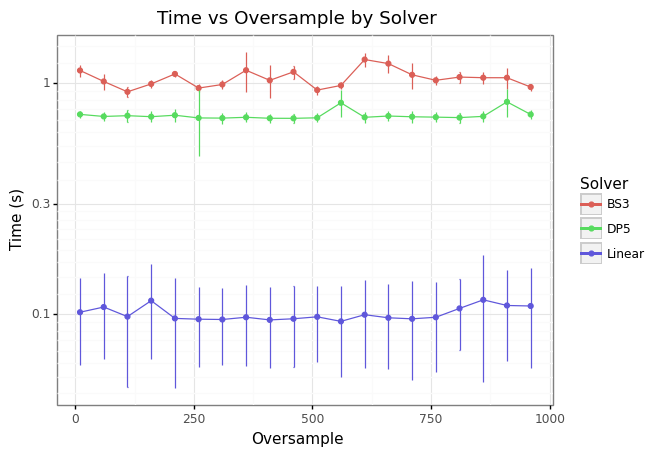

<ggplot: (8758820354813)>

In [124]:
(ggplot(odeint_oversample_resids, \
    aes(x="Oversample", y="Time (s)", ymin="ymin", ymax="ymax", color="Solver"))
    + theme_bw()
    + geom_line()
    + geom_point()
    + geom_errorbar()
    + scale_y_log10()
    + ggtitle("Time vs Oversample by Solver"))

Experimental analysis follows

In [ ]:
results = {
    "module": [],
    "time": [],
    "type": []
}

for solver in odeint:# Iterating through the namespaces of odeint function 
    function_obj = generate_model(odeint[solver], 1008)

    r_profile = profile(function_obj.dc14_fine, parameters)
    results["module"].append(solver)
    results["time"].append(float(r_profile["average"]) * 1000)
    results["type"].append("odeint")

    g_profile = profile(jacrev(function_obj.log_likelihood), parameters)
    results["module"].append(solver)
    results["time"].append(float(g_profile["average"]) * 1000)
    results["type"].append("gradient")

    h_profile = profile(jacfwd(jacrev(function_obj.log_likelihood)), parameters)
    results["module"].append(solver)
    results["time"].append(float(h_profile["average"]) * 1000)
    results["type"].append("hessian")


In [ ]:
results = DataFrame(results)  # Switching to a pandas data frame
(ggplot(results, aes(x="module", y="time", fill="type"))
    + geom_col(position="dodge")
    + geom_label(aes(label="round(time)"), position=position_dodge(width=0.9))
    + scale_y_log10()
    + theme_bw())